### 操作変数が連続な場合

- モデルを拡張する場合には、より洗練された手法が必要になる

- 状態変数のみ離散近似をして、操作変数については連続的な値を取り、価値関数を状態変数の間の値で評価するときは内挿法を用いる

- アルゴリズム


1. グリッド生成：状態空間の評価点を$I=21$個のグリッドに区切る。また、グリッド上における価値関数$V^{(0)}(k^{i})$の初期値を当て推量(initial guess)する

2. 収束の基準：収束の基準になるパラメータ$\varepsilon=10^{-5}$を与える

3. 近似・評価：$k^{i}$上にない価値関数の値については近似する必要がある。$V(k;\mathbb{b})$をパラメータ$\mathbb{b}$を使って近似した時の、$k$上での価値関数の値とする

4. 最適化：各$k^{i}$について、

$$
  V^{(1)}(k^{i}) = \max_{k'} u([k^{i}]^{\alpha}+(1-\delta)k^{i}-k') + \beta V^{(0)}(k';\mathbb{b})
$$

を計算する。価値関数を最大にする$k'$を探すためには、各言語の最適化関数を利用する

5. 全ての$k^{i}$について$\|V^{(0)}(k^{i})-V^{(1)}(k^{i})\|<\varepsilon$であればストップ。そうでなければ、$V^{(1)}(k^{i})$を$V^{(0)}(k^{i})$に代入して、ステップ3-4を繰り返す

In [1]:
def CRRA(m,cons):
        """
        ------------------------------
        === CRRA Utility Function ===
        ------------------------------
        <inputs>
        ・m: パラメータ等を格納したコンストラクタ
        ・cons: 消費量
        ・gamma: 異時点間の代替弾力性の逆数(相対的リスク回避度)
        <output>
        ・consとgamma の下での効用水準
        """
        # import numpy as np
        gamma = m.gamma
        
        if cons <0: 
            utility = -10000 #消費量が負値の場合、ペナルティを与える(最適化問題におけるトリック)
        else:
            if gamma != 1:
                utility = (cons ** (1-gamma)) / (1-gamma)
            else:
                utility = np.log(cons)
                
        return utility

In [2]:
def BellmanEq(m,capital,kprime,v_interp):
    """
    -----------------------------------------------
    === (k,k')を所与とした時にベルマン方程式を返す関数 ===
    -----------------------------------------------
    <input>
    ・m: パラメータ等を格納したコンストラクタ
    ・capital: 今期の資本保有量(k)
    ・kprime: 来期の資本保有量(k')
    ・v_: 補間した来期の価値関数
    (※Matlabコード上ではBellmanEq関数内で補間した価値関数を定義しているが、
    今回は明示的に関数の引数として扱う(capitalも同様))
    <output>
    ・value: (k,k')に対するベルマン方程式
    (※コード上では"最小化問題"を解くので符号を反転させた値を返す)
    """
    # from CRRA import CRRA

    alpha, beta = m.alpha, m.beta

    if kprime < 0: #(1): k'は正の値しか取らないので、ペナルティを与えてその値が選ばれないようにする
        
        value = -1000000.0
    
    else:

        wealth = capital ** alpha #今期の資本保有量で実現される生産量
        cons = wealth - kprime #消費量
        util = CRRA(m,cons) #効用水準
        value = util + beta*v_interp(kprime) #u(c)+βV_{t+1}(k')

    value = -1*value #(2): コード上では"最小化問題"を解くので符号を反転させた値を返す

    return value

In [3]:
#必要な関数・モジュールを呼び出す
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from scipy.interpolate import interp1d
from scipy.optimize import fmin
# from CRRA import CRRA, mu_CRRA
# from BellmanEq import BellmanEq

In [4]:
#STEP 1(a): カリブレーション & グリッド生成
class Model():
    """
    モデルを解くためのパラメータを含む class を定義する。
    """
    def __init__(self,
        beta = 0.96,  # 割引因子
        gamma = 1.0,  # 相対的リスク回避度(異時点間の代替弾力性の逆数)
        alpha = 0.4,  # 資本分配率 
        delta = 1.0,  # 固定資本減耗
        nk = 21,      # 資本のグリッド数
        kmax = 0.5,   # 資本グリッドの最大値
        kmin = 0.05,  # 資本グリッドの最小値
        maxit = 1000, # 繰り返し計算の最大値
        tol = 1e-5,   # 許容誤差(STEP 4)
        ): 
        
        self.beta, self.gamma, self.alpha = beta, gamma, alpha 
        self.delta, self.nk = delta, nk 
        self.kmax, self.kmin = kmax, kmin 
        self.maxit, self.tol = maxit, tol
        self.kgrid = np.linspace(kmin,kmax,nk) # 資本のグリッド

In [5]:
#収束に関するパラメータ
it = 1 #ループ・カウンター
dif1 = 1.0 #価値関数の繰り返し誤差
dif2 = 1.0 #政策関数の繰り返し誤差

# print("-+- Solve a Neoclassical Growth Model -+-")

#STEP 1(b): 価値関数・政策関数の初期値を設定
m = Model()
CRRA_vec = np.vectorize(CRRA) #CRRA関数をベクトル化する(配列を引数に取れるようにする)

vfcn0 = CRRA_vec(m,m.kgrid**m.alpha + (1-m.delta)*m.kgrid) #より良い価値関数の初期値を与える
pfcn0 = np.ones_like(vfcn0)
vfcn1 = np.zeros_like(vfcn0)
pfcn1 = np.zeros_like(vfcn0)
v_conv = [] #価値関数の繰り返し誤差を記録していく。各繰り返しごとにリストに追加していく。
p_conv = [] #政策関数の繰り返し誤差を記録していく。

- およそ200回で繰り返し計算誤差は$\varepsilon=1.0^{-5}$以下になる

- 価値関数の繰り返し計算誤差より政策関数の繰り返し計算誤差の方が早く0に近づいている

In [6]:
#STEP 2: 価値関数を繰り返し計算
while (it<m.maxit) & (dif1>m.tol):

    #ベルマン方程式: V(k;k')
    for i in range(m.nk):
        
        capital = m.kgrid[i]
        v_interp = interp1d(m.kgrid,vfcn0,kind="cubic",fill_value="extrapolate") #価値関数について3次のスプライン補間
        Bellman = lambda x: BellmanEq(m,capital,x,v_interp) #ベルマン方程式をk'のみの関数にする
        
        #最適化関数(fmin)を使って、所与のkに対して最適なk'を探す(符号を反転させているので、"最小化"問題。)
        pfcn1[i] = fmin(Bellman,x0=0.01,disp=False)
        vfcn1[i] = -Bellman(pfcn1[i]) #符号を反転させる

    #繰り返し誤差を確認
    dif1 = np.max(np.abs((vfcn1-vfcn0)/vfcn0))
    dif2 = np.max(np.abs((pfcn1-pfcn0)/pfcn0)) 
    
    #価値関数・政策関数をアップデート
    vfcn0 = np.copy(vfcn1)
    pfcn0 = np.copy(pfcn1)

    print(f"iteration index: {it}")
    print(f"value function iteration error: {dif1:.7f}")
    print(f"policy function iteration error: {dif2:.7f}")

    #収束途中の繰り返し計算誤差を保存
    v_conv.append(dif1)
    p_conv.append(dif2)

    it += 1

#消費関数を政策関数を下に計算
cfcn = m.kgrid ** m.alpha + (1-m.delta)*m.kgrid - pfcn0

iteration index: 1
value function iteration error: 3.3317886
policy function iteration error: 0.9163750
iteration index: 2
value function iteration error: 0.8300218
policy function iteration error: 0.2532216
iteration index: 3
value function iteration error: 0.4511127
policy function iteration error: 0.0674365
iteration index: 4
value function iteration error: 0.3022973
policy function iteration error: 0.0231397
iteration index: 5
value function iteration error: 0.2239479
policy function iteration error: 0.0086130
iteration index: 6
value function iteration error: 0.1759961
policy function iteration error: 0.0034682
iteration index: 7
value function iteration error: 0.1437827
policy function iteration error: 0.0014680
iteration index: 8
value function iteration error: 0.1207173
policy function iteration error: 0.0007153
iteration index: 9
value function iteration error: 0.1034186
policy function iteration error: 0.0005394
iteration index: 10
value function iteration error: 0.0899810
po

iteration index: 83
value function iteration error: 0.0014577
policy function iteration error: 0.0000000
iteration index: 84
value function iteration error: 0.0013974
policy function iteration error: 0.0000000
iteration index: 85
value function iteration error: 0.0013396
policy function iteration error: 0.0000000
iteration index: 86
value function iteration error: 0.0012843
policy function iteration error: 0.0000000
iteration index: 87
value function iteration error: 0.0012314
policy function iteration error: 0.0000000
iteration index: 88
value function iteration error: 0.0011807
policy function iteration error: 0.0000000
iteration index: 89
value function iteration error: 0.0011321
policy function iteration error: 0.0000000
iteration index: 90
value function iteration error: 0.0010856
policy function iteration error: 0.0000000
iteration index: 91
value function iteration error: 0.0010410
policy function iteration error: 0.0000000
iteration index: 92
value function iteration error: 0.0

iteration index: 162
value function iteration error: 0.0000560
policy function iteration error: 0.0000000
iteration index: 163
value function iteration error: 0.0000538
policy function iteration error: 0.0000000
iteration index: 164
value function iteration error: 0.0000516
policy function iteration error: 0.0000000
iteration index: 165
value function iteration error: 0.0000495
policy function iteration error: 0.0000000
iteration index: 166
value function iteration error: 0.0000476
policy function iteration error: 0.0000000
iteration index: 167
value function iteration error: 0.0000456
policy function iteration error: 0.0000000
iteration index: 168
value function iteration error: 0.0000438
policy function iteration error: 0.0000000
iteration index: 169
value function iteration error: 0.0000421
policy function iteration error: 0.0000000
iteration index: 170
value function iteration error: 0.0000404
policy function iteration error: 0.0000000
iteration index: 171
value function iteration 

In [7]:
#解析的解
AA = (1-m.beta)**(-1) * (np.log(1-m.alpha*m.beta) + ((m.alpha*m.beta)/(1-m.alpha*m.beta))*np.log(m.alpha*m.beta))
BB = m.alpha/(1-m.alpha*m.beta)
v_true = AA + BB*np.log(m.kgrid)
p_true = m.beta * m.alpha * (m.kgrid ** m.alpha)

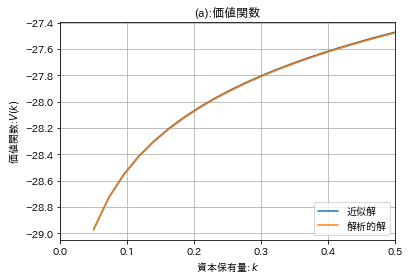

In [8]:
fig, ax = plt.subplots()
ax.plot(m.kgrid,vfcn0,label="近似解")
ax.plot(m.kgrid,v_true,label="解析的解")
ax.set(title="(a):価値関数",xlabel=r"資本保有量: $k$", ylabel=r"価値関数:$V(k)$",xlim=(0,m.kmax))
ax.legend(loc="lower right")
ax.grid()
plt.show()

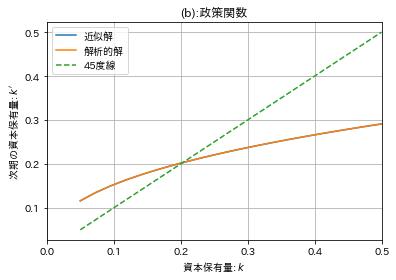

In [9]:
fig, ax = plt.subplots()
ax.plot(m.kgrid, pfcn0, label="近似解")
ax.plot(m.kgrid, p_true, label="解析的解")
ax.plot(m.kgrid, m.kgrid, ls="--", label="45度線")
ax.set(title="(b):政策関数",xlabel=r"資本保有量: $k$", ylabel=r"次期の資本保有量: $k'$",xlim=(0,m.kmax))
ax.legend(loc="upper left")
ax.grid()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


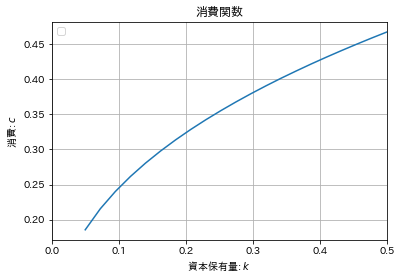

In [10]:
fig, ax = plt.subplots()
ax.plot(m.kgrid, cfcn)
ax.set(title="消費関数",xlabel=r"資本保有量: $k$", ylabel=r"消費: $c$",xlim=(0,m.kmax))
ax.legend(loc="upper left")
ax.grid()
plt.show()

- オイラー方程式$u'(c)=\beta u'(f(k')-g(k'))f'(k')$における計算誤差は、以下の式で得られる

$$
  \frac{\beta u'\big([g(k^{i})]^{\alpha}-g(g(k^{i}))\big)f'(g(k^{i}))}{u'\big([k^{i}]^{\alpha}-g(k^{i})\big)}-1
$$

ここで、$k'=g(k)$である

In [11]:
def mu_CRRA(m,cons):
        """
        --------------------------------------
        === CRRA Marginal Utility Function ===
        --------------------------------------
        <inputs>
        ・m: パラメータ等を格納したコンストラクタ
        ・cons: 消費量
        <output>
        ・consとgamma の下での限界効用水準
        """
        gamma = m.gamma
        mu = cons ** (-gamma)

        return mu

In [12]:
# %% オイラー方程式から誤差を測定
# kgrid_err = linspace(kmin, kmax, (nk-1)*10+1)';
# %kgrid_err = kgrid; %linspace(kmin, kmax, (nk-1)*10+1)';
# kp = interp1(kgrid,pfcn0(:,1),kgrid_err); % 線形補間
# %kp   = pfcn0(:,1);
# cons = kgrid_err.^alpha + (1.-delta).*kgrid_err - kp;
# LHS  = mu_CRRA(cons, gamma);

# kpp  = interp1(kgrid, pfcn0(:,1), kp);
# cnext = kp.^alpha + (1.-delta).*kp - kpp;
# rent = alpha.*kp.^(alpha-1.0) - delta;
# RHS  = beta.*(1.+rent).*mu_CRRA(cnext, gamma);

# err  = RHS./LHS-1.0;

In [13]:
#オイラー方程式から誤差を計算
mu_CRRA_vec = np.vectorize(mu_CRRA) #mu_CRRA関数をベクトル化する

# original grid
kp_interp = interp1d(m.kgrid,pfcn0,kind="linear",fill_value="extrapolate") #政策関数を補間する
LHS = mu_CRRA(m,cfcn) #今期の消費水準についての限界効用
cons_p = (pfcn0 ** m.alpha) + (1-m.delta)*pfcn0 - kp_interp(pfcn0)
rent = m.alpha*(pfcn0**(m.alpha-1)) -m.delta #r=f'(k)-\delta
RHS = m.beta*(1+rent) * mu_CRRA_vec(m,cons_p)
err_org = (RHS/LHS) - 1

# finer grid
kp_interp = interp1d(m.kgrid,pfcn0,kind="linear",fill_value="extrapolate") #政策関数を補間する
kgrid_err = np.linspace(m.kmin, m.kmax, (m.nk-1)*10+1);
kp = kp_interp(kgrid_err)
cons = (kgrid_err ** m.alpha) + (1-m.delta)*kgrid_err - kp
LHS = mu_CRRA(m,cons) #今期の消費水準についての限界効用

kpp = kp_interp(kp)
cons_p = (kp ** m.alpha) + (1-m.delta)*kp - kpp #kp_interp(pfcn0)
rent = m.alpha*(kp**(m.alpha-1)) -m.delta #r=f'(k)-\delta
RHS = m.beta*(1+rent) * mu_CRRA_vec(m,cons_p)
err = (RHS/LHS) - 1

# f = open("err_ddp.csv",encoding='utf-8-sig')
# err2 = np.loadtxt(f) #離散化した場合のオイラー方程式誤差

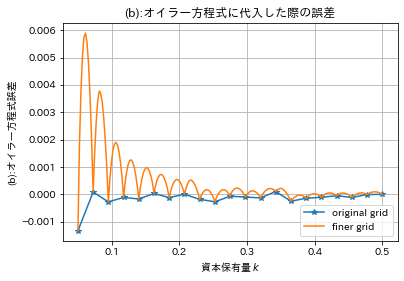

In [14]:
fig, ax = plt.subplots()
# ax.plot(m.kgrid,err2,label="操作変数:離散")
# ax.plot(m.kgrid,err_org,'*-',label="操作変数:連続")
# ax.plot(kgrid_err,err,label="操作変数:連続")
ax.plot(m.kgrid,err_org,'*-',label="original grid")
ax.plot(kgrid_err,err,label="finer grid")
# ax.set(xlabel=r"資本保有量 $k$", ylabel="(b):オイラー方程式誤差",ylim=(-15e-4,5e-4),title="(b):オイラー方程式に代入した際の誤差")
ax.set(xlabel=r"資本保有量 $k$", ylabel="(b):オイラー方程式誤差",title="(b):オイラー方程式に代入した際の誤差")
ax.legend(loc="lower right")
ax.grid()
plt.show()

# f = open("err_cdp.csv",encoding='utf-8-sig')
np.savetxt("err_cdp.csv",err) #離散化した場合のオイラー方程式誤差